In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import os 
content_dir = os.getcwd() + '/test_content/'
style_dir = os.getcwd() + '/test_style/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

In [17]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        # vgg modules
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000)
        )

    def forward(self, x, out_keys):
        out = {}
        out['r11'] = self.features[0](x)
        out['r12'] = self.features[1](out['r11'])
        out['p1'] = self.features[2](out['r12'])
        out['r21'] = self.features[3](out['p1'])
        out['r22'] = self.features[4](out['r21'])
        out['p2'] = self.features[5](out['r22'])
        out['r31'] = self.features[6](out['p2'])
        out['r32'] = self.features[7](out['r31'])
        out['r33'] = self.features[8](out['r32'])
        out['r34'] = self.features[9](out['r33'])
        out['p3'] = self.features[10](out['r34'])
        out['r41'] = self.features[11](out['p3'])
        out['r42'] = self.features[12](out['r41'])
        out['r43'] = self.features[13](out['r42'])
        out['r44'] = self.features[14](out['r43'])
        out['p4'] = self.features[15](out['r44'])
        out['r51'] = self.features[16](out['p4'])
        out['r52'] = self.features[17](out['r51'])
        out['r53'] = self.features[18](out['r52'])
        out['r54'] = self.features[19](out['r53'])
        out['p5'] = self.features[20](out['r54'])
        return [out[key] for key in out_keys]

In [18]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [19]:
class LaplacianNetwork(nn.Module):
    def __init__(self, in_channels=3):
        super(LaplacianNetwork, self).__init__()
        # pooling layer
        self.pooling_layer = nn.AvgPool2d(kernel_size=4, stride=4)
        # laplacian filter
        laplacian_filter = torch.Tensor([[0, -1, 0],
                                         [-1, 4, -1],
                                         [0, -1, 0]])
        laplacian_filter = laplacian_filter.view(1, 1, 3, 3).repeat(1, in_channels, 1, 1)
        self.laplacian_filter = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1, bias=False)
        self.laplacian_filter.weight = nn.Parameter(laplacian_filter)

    def forward(self, x):
        x = self.pooling_layer(x)
        x = self.laplacian_filter(x)
        return x


In [20]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [21]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
#from torchvision import transforms, models
#vgg = models.vgg19(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

lap = LaplacianNetwork()
for param in lap.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    lap.cuda()

/tmp/ipykernel_4123/3532491001.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))


In [57]:
#load images, ordered as [style_image, content_image]
img_dirs = [style_dir,content_dir]
content_names = [f for f in os.listdir(content_dir) if os.path.isfile(os.path.join(content_dir, f))]
style_names = [f for f in os.listdir(style_dir) if os.path.isfile(os.path.join(style_dir, f))]

In [ ]:
content_names

['Tuebingen_Neckarfront.jpg']

In [76]:
from PIL import Image
import os



content_imgs=[]

# 缩小每张图片为原本的1/2大小
for img_name in style_names:
    img_path = img_dirs[0]+img_name
    img = Image.open(img_path)
    
    # 缩小图片尺寸
    img_resized = img.resize((img.width // 2, img.height // 2))
    
    content_imgs.append(img_resized)

In [77]:
print(content_imgs)

[<PIL.Image.Image image mode=RGB size=485x384 at 0x7FB5F3B245C0>]


['Tuebingen_Neckarfront.jpg']
['vangogh_starry_night.jpg']


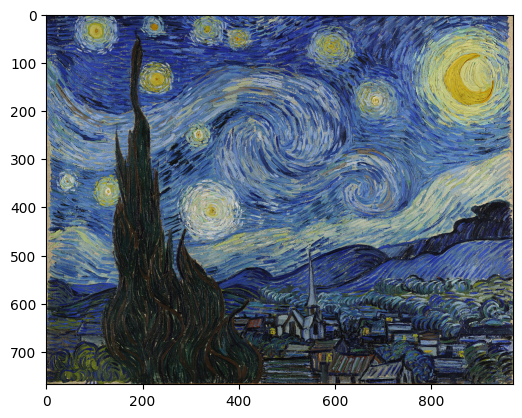

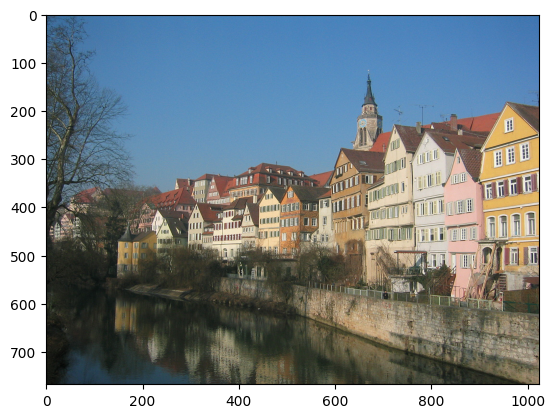

Iteration: 50, loss: 19251398656.000000
Iteration: 100, loss: 5414111232.000000
Iteration: 150, loss: 1513079424.000000
Iteration: 200, loss: 750015744.000000
Iteration: 250, loss: 492216352.000000
Iteration: 300, loss: 325032800.000000
Iteration: 350, loss: 223696464.000000
Iteration: 400, loss: 153541008.000000
Iteration: 450, loss: 108547128.000000
Iteration: 500, loss: 77732000.000000
Iteration: 550, loss: 58523188.000000
Iteration: 600, loss: 44634788.000000
Iteration: 650, loss: 35843684.000000
Iteration: 700, loss: 29144758.000000
Iteration: 750, loss: 24669932.000000
Iteration: 800, loss: 21321880.000000
Iteration: 850, loss: 18577802.000000
Iteration: 900, loss: 16448212.000000
Iteration: 950, loss: 14702421.000000
Iteration: 1000, loss: 13400815.000000
Iteration: 1050, loss: 12265328.000000
Iteration: 1100, loss: 11286156.000000
Iteration: 1150, loss: 10414868.000000
Iteration: 1200, loss: 9720170.000000
Iteration: 1250, loss: 9111521.000000
Iteration: 1300, loss: 8564694.000

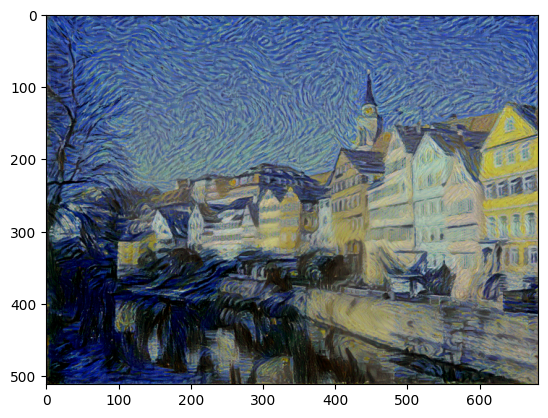

<Figure size 1000x1000 with 0 Axes>

In [96]:
print(content_names)
print(style_names)
for cn in content_names:
    for sn in style_names:
        img_names = [sn,cn]
        imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
        imgs_torch = [prep(img) for img in imgs]
        if torch.cuda.is_available():
            imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
        else:
            imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
        style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
        opt_img = Variable(content_image.data.clone(), requires_grad=True)
        for img in imgs:
            plt.imshow(img);plt.show()
        #define layers, loss functions, weights and compute optimization targets
        style_layers = ['r11','r21','r31','r41', 'r51'] 
        content_layers = ['r32']
        loss_layers = style_layers + content_layers
        loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
        if torch.cuda.is_available():
            loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
        #these are good weights settings:
        style_weights = [1e8/n**2 for n in [64,128,256,512,512]]
        content_weights = [1e0]
        weights = style_weights + content_weights
        
        #compute optimization targets
        style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
        content_targets = [A.detach() for A in vgg(content_image, content_layers)]
        targets = style_targets + content_targets

        lap_target = lap(content_image)

        #run style transfer
        max_iter = 2000
        show_iter = 50
        optimizer = optim.LBFGS([opt_img],lr=1)
        optimizer = optimizer
        n_iter=[0]

        while n_iter[0] <= max_iter:
            torch.cuda.empty_cache()
            def closure():

                optimizer.zero_grad()
                out = vgg(opt_img, loss_layers)
                layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
                loss_lap = nn.MSELoss()(lap(opt_img),lap_target)
                loss = torch.sum(torch.stack(layer_losses)) + loss_lap*100
                loss.backward()
                n_iter[0]+=1
                if n_iter[0]%show_iter == (show_iter-1):
                    print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
                return loss
            optimizer.step(closure)
            if n_iter[0] >= max_iter:
                break
        #display result
        out_img = postp(opt_img.data[0].cpu().squeeze())
        plt.imshow(out_img)
        plt.show()
        plt.gcf().set_size_inches(10,10)

In [97]:
out_img1 = postp(opt_img.data[0].cpu().squeeze())

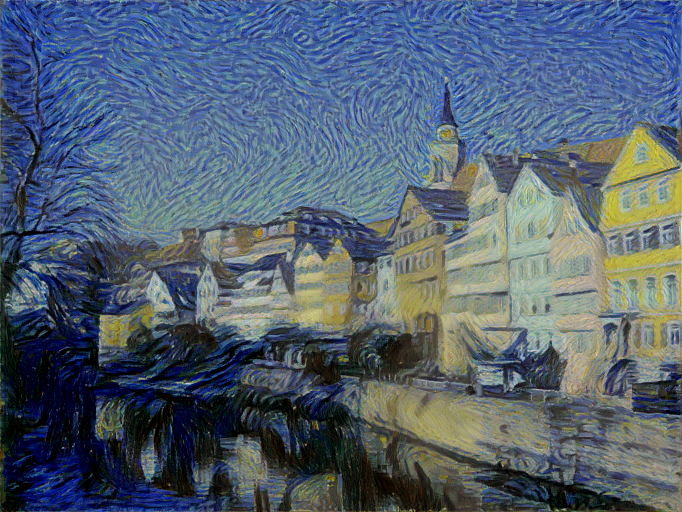

In [98]:
out_img1